In [1]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("kmeans").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [9]:
path ="d:\\"
dti = spark.read.csv(path+'titanic.csv',inferSchema=True,header=True)

In [18]:
dti.limit(5).toPandas()

,Survived,Pclass,Name,Sex,Age,SiblingsSpouses,ParentsChildren,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [19]:
dti.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SiblingsSpouses: integer (nullable = true)
 |-- ParentsChildren: integer (nullable = true)
 |-- Fare: double (nullable = true)



In [22]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(dti)
print("Null COlumns calc list " ,null_columns_calc_list)
#spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()


Null COlumns calc list  []


In [39]:
from pyspark.ml.feature import StringIndexer
g=StringIndexer(inputCol='Sex',outputCol='Gen_Col')
v=g.fit(dti).transform(dti)
dt=v.drop('Sex','Name')

In [40]:
from pyspark.ml.feature import VectorAssembler
input_columns = dt.columns # Collect the column names as a list
input_columns = input_columns[1:] # keep only relevant columns: from column 8 until the end
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
dt_kmeans = vecAssembler.transform(dt) #.select('CUST_ID', 'features')
dt_kmeans.limit(4).toPandas()

,Survived,Pclass,Age,SiblingsSpouses,ParentsChildren,Fare,Gen_Col,features
0,0,3,22.0,1,0,7.2500,0.0,"[3.0, 22.0, 1.0, 0.0, 7.25, 0.0]"
1,1,1,38.0,1,0,71.2833,1.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0]"
2,1,3,26.0,0,0,7.9250,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 1.0]"
3,1,1,35.0,1,0,53.1000,1.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0]"


In [42]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
kmax = 50
kmcost = np.zeros(kmax)
print(kmcost)
for k in range(2,kmax):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(dt_kmeans)
    predictions = model.transform(dt_kmeans)
    evaluator = ClusteringEvaluator()
    kmcost[k] = evaluator.evaluate(predictions) #computing Silhouette score
    
print(kmcost)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0.         0.         0.97406795 0.91497372 0.81922853 0.78148193
 0.60385217 0.49200774 0.61372646 0.60968895 0.60434023 0.62893952
 0.60060975 0.56486044 0.57940103 0.57934825 0.57728547 0.52787228
 0.59366382 0.57951056 0.59147428 0.5292159  0.56337806 0.59997166
 0.54245571 0.57523814 0.57085226 0.54190741 0.59590609 0.51410167
 0.52373749 0.54415796 0.52777644 0.5505415  0.52814098 0.53622115
 0.52010412 0.53037725 0.55355835 0.52338034 0.5304636  0.53219158
 0.51564929 0.51189597 0.51575261 0.51651365 0.51870184 0.53031097
 0.49229003 0.5214153 ]


In [43]:
predictions.show(10)

+--------+------+----+---------------+---------------+-------+-------+--------------------+----------+
|Survived|Pclass| Age|SiblingsSpouses|ParentsChildren|   Fare|Gen_Col|            features|prediction|
+--------+------+----+---------------+---------------+-------+-------+--------------------+----------+
|       0|     3|22.0|              1|              0|   7.25|    0.0|[3.0,22.0,1.0,0.0...|         0|
|       1|     1|38.0|              1|              0|71.2833|    1.0|[1.0,38.0,1.0,0.0...|        27|
|       1|     3|26.0|              0|              0|  7.925|    1.0|[3.0,26.0,0.0,0.0...|        44|
|       1|     1|35.0|              1|              0|   53.1|    1.0|[1.0,35.0,1.0,0.0...|        11|
|       0|     3|35.0|              0|              0|   8.05|    0.0|[3.0,35.0,0.0,0.0...|        10|
|       0|     3|27.0|              0|              0| 8.4583|    0.0|[3.0,27.0,0.0,0.0...|        44|
|       0|     1|54.0|              0|              0|51.8625|    0.0|[1.

Text(0, 0.5, 'cost')

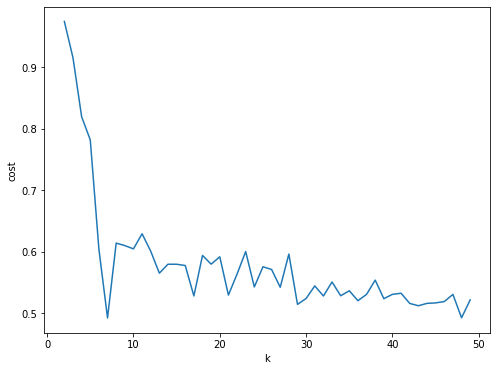

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),kmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [45]:
#Bisecting Kmeans
from pyspark.ml.clustering import BisectingKMeans

# Same calls here except with bkmeans
kmax = 50
bkmcost = np.zeros(kmax)
for k in range(2,kmax):
    bkmeans = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = bkmeans.fit(dt_kmeans)
    
   
    predictions = model.transform(dt_kmeans)
    evaluator = ClusteringEvaluator()
    bkmcost[k] = evaluator.evaluate(predictions) #computes Silhouette score

Text(0, 0.5, 'cost')

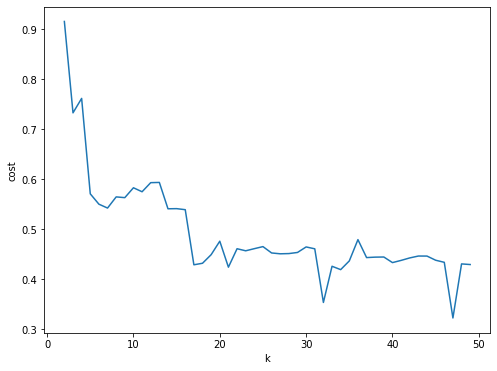

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

Text(0, 0.5, 'cost')

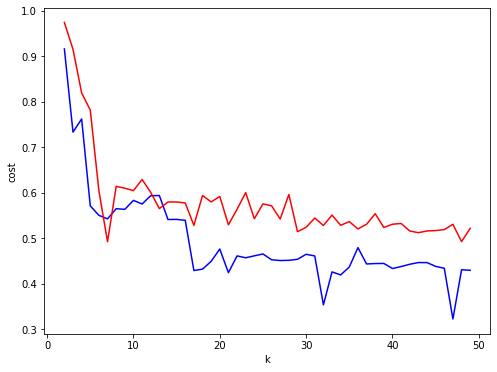

In [47]:
#Let's plot both graphs together
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(range(2,kmax),bkmcost[2:kmax],color='blue')
ax.plot(range(2,kmax),kmcost[2:kmax],color='red')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [48]:
def compare(bkmcost,kmcost):
    diff = []
    for k in range(2,kmax,2):
        temp = k,(kmcost[k]-bkmcost[k])
        diff.append(temp)
    return(diff)

diff_list = compare(bkmcost,kmcost)
diff_list

[(2, 0.05810468814615222),
 (4, 0.05732417023454717),
 (6, 0.05378396637656557),
 (8, 0.04908313276102527),
 (10, 0.02140584150338931),
 (12, 0.007451197678912003),
 (14, 0.038559261505199394),
 (16, 0.038232627064514135),
 (18, 0.16190843973843655),
 (20, 0.11555483056694016),
 (22, 0.10252718010401579),
 (24, 0.08148050447816096),
 (26, 0.1184713771056144),
 (28, 0.1447619762260911),
 (30, 0.05930842931938057),
 (32, 0.17451704375977212),
 (34, 0.10914847405590833),
 (36, 0.04103895341052233),
 (38, 0.10955279961762704),
 (40, 0.09738892375115044),
 (42, 0.07320850280325353),
 (44, 0.06961056706949187),
 (46, 0.08506163308587078),
 (48, 0.0618347043541993)]

In [50]:
k = 18
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(dt_kmeans)
predictions = model.transform(dt_kmeans)
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))
print(" ")
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.5936638190321427
 
Cluster Centers: 
[1.85294118e+00 6.22794118e+01 2.94117647e-02 8.82352941e-02
 1.87653176e+01 1.76470588e-01]
[ 2.73684211  5.50328947  1.78947368  1.30263158 24.94802632  0.5       ]
[ 1.61111111 45.06481481  0.2962963   0.81481481 30.20856296  0.31481481]
[1.00000000e+00 3.53333333e+01 0.00000000e+00 3.33333333e-01
 5.12329200e+02 3.33333333e-01]
[  1.          11.98666667   0.66666667   1.33333333 138.38055
   0.5       ]
[ 2.75301205 30.29518072  0.1626506   0.05421687  9.76425361  0.25301205]
[ 2.85714286 20.41964286  0.17857143  0.07142857  9.02663795  0.29017857]
[ 1.         46.61290323  0.77419355  0.32258065 81.2565871   0.64516129]
[ 1.19230769 46.92307692  0.65384615  0.53846154 54.59648462  0.38461538]
[ 1.83870968 23.93548387  1.25806452  0.61290323 50.99542903  0.38709677]
[1.00000000e+00 3.40000000e+01 1.11111111e-01 4.44444444e-01
 2.19710189e+02 6.66666667e-01]
[ 2.6        43.34666667  0.09333333  0.1

In [55]:
predictions.groupBy("prediction").agg(min(predictions.Age).alias("Min Age"),max(predictions.Age).alias("Max Age")).show(15)

+----------+-------+-------+
|prediction|Min Age|Max Age|
+----------+-------+-------+
|        12|   18.0|   24.0|
|         1|   0.42|   16.0|
|        13|   17.0|   58.0|
|         6|   12.0|   25.0|
|        16|    4.0|   32.0|
|         3|   35.0|   36.0|
|         5|   26.0|   37.0|
|        15|   18.0|   37.0|
|         9|    9.0|   35.0|
|        17|   50.0|   64.0|
|         4|   0.92|   22.0|
|         8|   37.0|   71.0|
|         7|   33.0|   70.0|
|        10|   15.0|   49.0|
|        11|   37.0|   55.5|
+----------+-------+-------+
only showing top 15 rows

